# Introduction

The goal of this project is to explore a data-driven stock screener based on the US stock market data. This Python Notebook examines several approaches for modeling stock data and eventually predicting the top trending stocks to buy. We will explore several techniques that have already been developed (commonly known as Technical Analysis) and the Python implementations. 

Technical analysis is the study of data generated from the market and from the actions of people in the market. Such data includes price levels that have served as turning points in the past, several macroeconomic indicators, the amounts of stock being bought and sold each day (volume), and the rate of change of price movements (momentum) over a given span of time.

The steps are to explore models for identifying the trending securities, to develop Python code for the popular models, and to eventually develop trading strategies. 

#### Data Collection and Modeling

The data we need for the analysis will be collected from the Quandl API -- a popular source for financial, economic, and alternative datasets. Quandl delivers market data from hundreds of sources via an API, or directly into Python. Free API key is required to run this notebook (https://www.quandl.com).

#### Backtesting

Backtesting is the process of testing a trading strategy on relevant historical data to ensure its viability before risking any actual capital. Quantopian is a web service that provides free backtesting with historical data. Quantopian provides us with everything we need to turn our technical analysis models into trading strategies. Here, we can do research using a variety of data sources, test the strategy over historical data, and then simulate going forward with live data (https://www.quantopian.com).

#### Scope

This notebook contains the code developed for the Data Collection and Modeling part of the project (Part 1). The backtesting and algorithmic trading experiments with the Quantopian service part of the project are not included here. Quantopian provides a powerful IDE (Python development environment) intergrated right into the web service (https://www.quantopian.com/algorithms/).

Required Python packages for this notebook: pandas, matplotlib, quandl, tabulate and (optionally) zipline.

#### Link to Live Notebook

We will use the Microsoft Azure Cloud Services for running the code (https://azure.microsoft.com). Using a cloud service like Azure alows one to easily scale-up when many stock symbols need to be analyzed in parallel with several years of historical data. A live version of this notebook is available here: https://notebooks.azure.com/rsujithan/libraries/FinanceNotebook

# Install and Initialize the packages

First we need to install and initialize the Python packages. The installation step needs to be done only once per notebook session (this may take a while).

In [1]:
!pip install quandl
!pip install tabulate

# Optional for backtesting with Quantopian
# !pip install zipline

In [2]:
# Import the Quandl API and configure the API key
import quandl
quandl.ApiConfig.api_key = "icjEB8FYLh6QyycLs6Xf"

In [3]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline

# Data Collection

Here we will show how to get the daily trading data for a given stock (say Apple, Inc.), usually the first step in any technical anaysis. The Quandl API is very powerful, there are several options you can pass to the API (https://docs.quandl.com/docs). The Quandl's get method returns a pandas dataframe so that we can use the built-in functions to do the analysis.

We will show the results for a single stock with six months worth of data. In practice, we run this analysis for all the stock symbols using the Microsoft Azure Cloud. In this notebook, we will primarily be using the following columns in the stock price dataframe: Open, High, Low, Close, Volume.

In [4]:
# We will use the Quandl service to get the data for six months for AAPL
start = pd.to_datetime('2017-04-01')
end = pd.to_datetime('2017-10-01')
stock_price_df = quandl.get('WIKI/AAPL', start_date=start, end_date=end)

# Print some general information about the results from Quandl
stock_price_df.info()

# Print the last 10 items to see what we got
print tabulate(stock_price_df[['Open', 'Close', 'High', 'Low', 'Volume']].tail(10), headers='keys', tablefmt='psql')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2017-04-03 to 2017-09-29
Data columns (total 12 columns):
Open           125 non-null float64
High           125 non-null float64
Low            125 non-null float64
Close          125 non-null float64
Volume         125 non-null float64
Ex-Dividend    125 non-null float64
Split Ratio    125 non-null float64
Adj. Open      125 non-null float64
Adj. High      125 non-null float64
Adj. Low       125 non-null float64
Adj. Close     125 non-null float64
Adj. Volume    125 non-null float64
dtypes: float64(12)
memory usage: 12.7 KB
+---------------------+--------+---------+---------+---------+-------------+
| Date                |   Open |   Close |    High |     Low |      Volume |
|---------------------+--------+---------+---------+---------+-------------|
| 2017-09-18 00:00:00 | 160.11 |  158.67 | 160.5   | 157.995 | 2.79397e+07 |
| 2017-09-19 00:00:00 | 159.51 |  158.73 | 159.77  | 158.44  | 2.03474e+07 |
| 2017-09-20 00:0

#### Work with downloaded CSV file

Sometimes the API may not work or not accessible through the internet. In that case the same data can be downloaded as a CSV file and loaded into pandas dataframe (using the read_csv method). The downloaded file can be very large, a service like Azure Cloud Storage is highly recommended. The rest of the analysis should work the same, regardless of how the data was obtained.

In [5]:
# Sometimes the API may not work, then we'll need work with CSV files
# stock_price_df = pd.read_csv('WIKI_PRICES_AAPL.csv', sep=',')
# stock_price_df.index = pd.to_datetime(stock_price_df.pop('date'))
# stock_price_df.info()

#### Create a plot function

We will use the matplotlib library to plot the various functions as we go along.

In [6]:
# Create a plot function
%matplotlib inline
def plot_series(df, columns, last_n, title):
    plot_df = df[columns].tail(last_n)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    plot_df.plot(ax=ax, figsize=(20,8))

# Modeling

## Moving Average

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 3 days, 7 days or 30 days (or any time period). We can do this using the pandas rolling mean function with a window size of n days (n is the input).

As you would expect, the moving average smoothes out the daily ups and downs to show the general trend. 

http://www.investopedia.com/terms/m/movingaverage.asp

In [7]:
# Moving Average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(min_periods=1, center=True, window=n).mean(), name = 'MA_' + str(n))
    df = df.join(MA)
    return df

### Calculate and plot moving average

MOVING AVERAGE
+---------------------+---------+---------+
| Date                |   Close |    MA_7 |
|---------------------+---------+---------|
| 2017-09-18 00:00:00 |  158.67 | 157.81  |
| 2017-09-19 00:00:00 |  158.73 | 156.701 |
| 2017-09-20 00:00:00 |  156.07 | 155.597 |
| 2017-09-21 00:00:00 |  153.39 | 154.634 |
| 2017-09-22 00:00:00 |  151.89 | 154     |
| 2017-09-25 00:00:00 |  150.55 | 153.221 |
| 2017-09-26 00:00:00 |  153.14 | 152.943 |
| 2017-09-27 00:00:00 |  154.23 | 152.868 |
| 2017-09-28 00:00:00 |  153.28 | 153.064 |
| 2017-09-29 00:00:00 |  154.12 | 153.692 |
+---------------------+---------+---------+


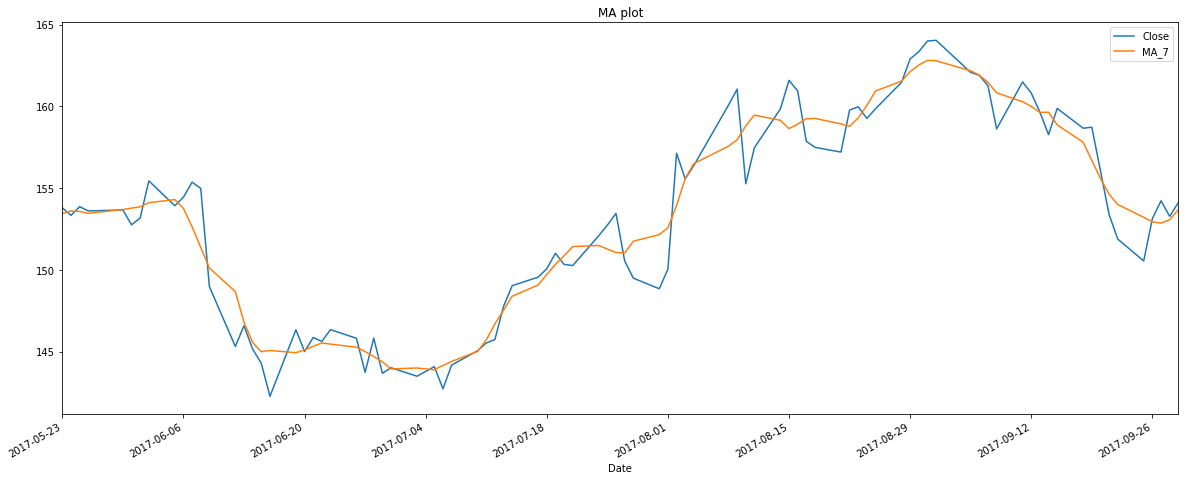

In [8]:
# Printing the Moving Average
print("MOVING AVERAGE")
stock_ma_df = MA(stock_price_df, 7)

# Print the last 10 items
print tabulate(stock_ma_df[['Close', 'MA_7']].tail(10), headers='keys', tablefmt='psql')

# Plot the moving averate for the last 90 days
plot_series(stock_ma_df, ['Close', 'MA_7'], 90, 'MA plot')

## Exponential Moving Average

An exponential moving average (EMA) is a type of moving average that is similar to a simple moving average, except that more weight is given to the latest data. It's also known as the exponentially weighted moving average (EWMA). This type of moving average reacts faster to recent price changes than a simple moving average. All the moving averages commonly used in technical analysis are, by their very nature, lagging indicators.

http://www.investopedia.com/terms/e/ema.asp

In [9]:
# Exponential Moving Average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods = 1).mean(), name='EMA_' + str(n))
    df = df.join(EMA)
    return df

### Calculate and plot exponential moving average

EXPONENTIAL MOVING AVERAGE
+---------------------+---------+---------+----------+
| Date                |   Close |    MA_7 |   EMA_14 |
|---------------------+---------+---------+----------|
| 2017-09-18 00:00:00 |  158.67 | 157.81  |  160.108 |
| 2017-09-19 00:00:00 |  158.73 | 156.701 |  159.924 |
| 2017-09-20 00:00:00 |  156.07 | 155.597 |  159.41  |
| 2017-09-21 00:00:00 |  153.39 | 154.634 |  158.608 |
| 2017-09-22 00:00:00 |  151.89 | 154     |  157.712 |
| 2017-09-25 00:00:00 |  150.55 | 153.221 |  156.757 |
| 2017-09-26 00:00:00 |  153.14 | 152.943 |  156.275 |
| 2017-09-27 00:00:00 |  154.23 | 152.868 |  156.002 |
| 2017-09-28 00:00:00 |  153.28 | 153.064 |  155.639 |
| 2017-09-29 00:00:00 |  154.12 | 153.692 |  155.437 |
+---------------------+---------+---------+----------+


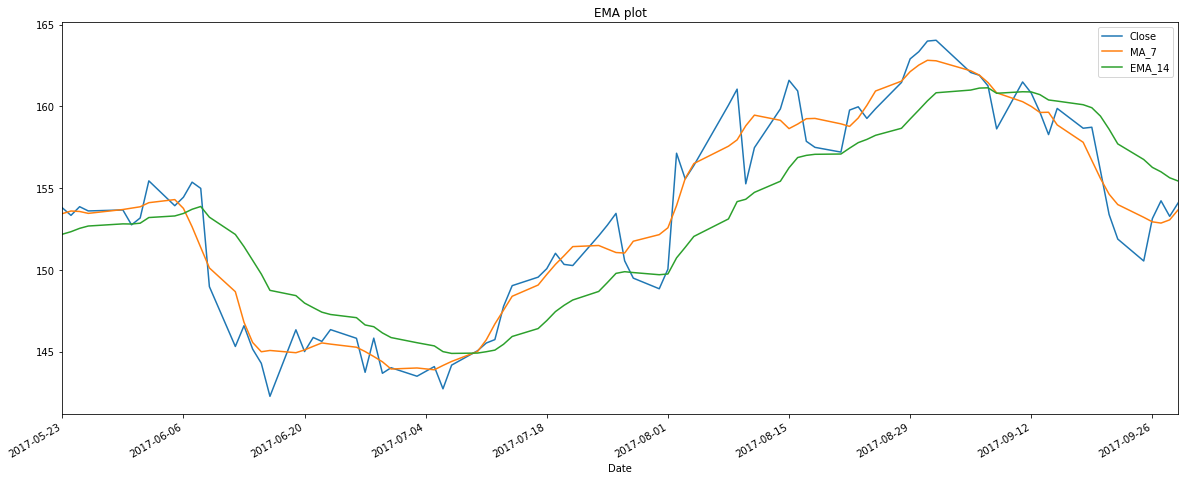

In [10]:
# Printing the Exponential Moving Average
print("EXPONENTIAL MOVING AVERAGE")
stock_ema_df = EMA(stock_ma_df,14)

# Print the last 10 items
print tabulate(stock_ema_df[['Close', 'MA_7', 'EMA_14']].tail(10), headers='keys', tablefmt='psql')

# Plot the moving averate for the last 90 days
plot_series(stock_ema_df, ['Close', 'MA_7', 'EMA_14'], 90, 'EMA plot')

## Momentum

Momentum measures the rate of the rise or fall in stock prices. From the standpoint of trending, momentum is a very useful indicator of strength or weakness in the issue's price. History has shown us that momentum is far more useful during rising markets than during falling markets; the fact that markets rise more often than they fall is the reason for this. 

http://www.investopedia.com/articles/technical/03/070203.asp

In [11]:
# Momentum  
def MOM(df, n):  
    M = pd.Series(df['Close'].diff(n), name = 'MOM_' + str(n))  
    df = df.join(M)  
    return df

MOMENTUM
+---------------------+---------+---------+
| Date                |   Close |   MOM_7 |
|---------------------+---------+---------|
| 2017-09-18 00:00:00 |  158.67 |   -2.59 |
| 2017-09-19 00:00:00 |  158.73 |    0.1  |
| 2017-09-20 00:00:00 |  156.07 |   -5.43 |
| 2017-09-21 00:00:00 |  153.39 |   -7.43 |
| 2017-09-22 00:00:00 |  151.89 |   -7.76 |
| 2017-09-25 00:00:00 |  150.55 |   -7.73 |
| 2017-09-26 00:00:00 |  153.14 |   -6.74 |
| 2017-09-27 00:00:00 |  154.23 |   -4.44 |
| 2017-09-28 00:00:00 |  153.28 |   -5.45 |
| 2017-09-29 00:00:00 |  154.12 |   -1.95 |
+---------------------+---------+---------+


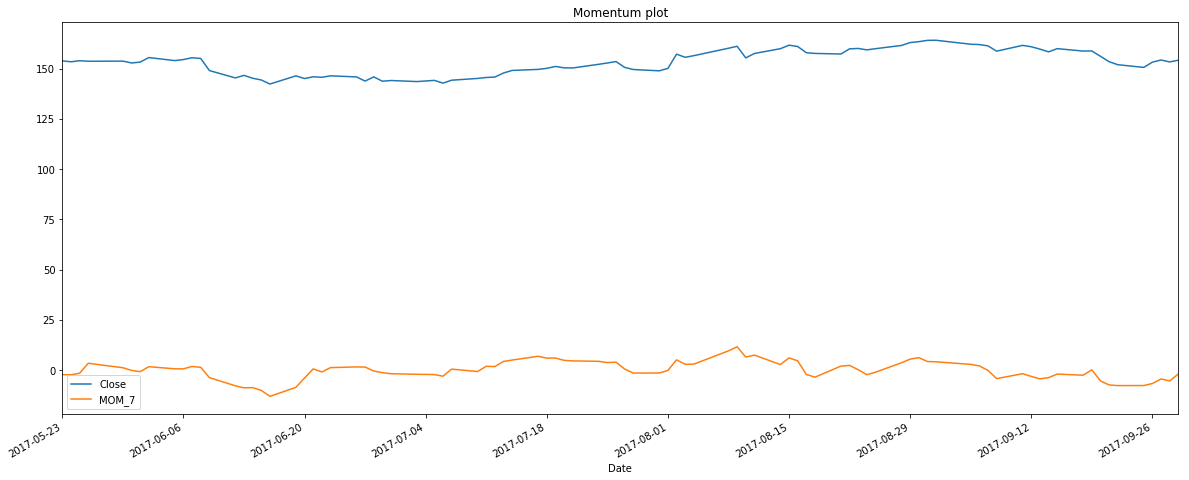

In [12]:
# Printing the Momentum Indicator
print("MOMENTUM")
stock_mom_df = MOM(stock_ema_df, 7)
# print stock_ema_df.info()
# print stock_ema_df.head()

print tabulate(stock_mom_df[['Close', 'MOM_7']].tail(10), headers='keys', tablefmt='psql')
plot_series(stock_mom_df, ['Close', 'MOM_7'], 90, 'Momentum plot')

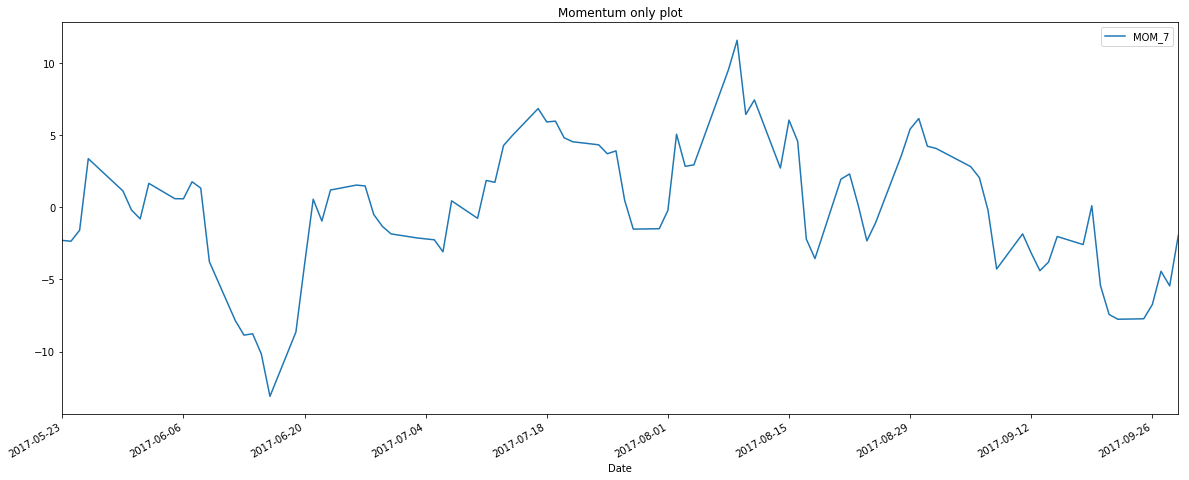

In [13]:
# Plot Momentum only
plot_series(stock_mom_df, ['MOM_7'], 90, 'Momentum only plot')

## Rate of Change  

Rate of Change (ROC) is often used when speaking about momentum, and it can generally be expressed as a ratio between a change in one variable relative to a corresponding change in another; graphically, the rate of change is represented by the slope of a line.

In [14]:
# Rate of Change  
def ROC(df, n):  
    M = df['Close'].diff(n - 1)  
    N = df['Close'].shift(n - 1)  
    ROC = pd.Series(M / N, name = 'ROC_' + str(n))  
    df = df.join(ROC)
    return df

RATE OF CHANGE
+---------------------+---------+--------------+
| Date                |   Close |        ROC_7 |
|---------------------+---------+--------------|
| 2017-09-18 00:00:00 |  158.67 |  0.000252159 |
| 2017-09-19 00:00:00 |  158.73 | -0.0171517   |
| 2017-09-20 00:00:00 |  156.07 | -0.0295361   |
| 2017-09-21 00:00:00 |  153.39 | -0.0392108   |
| 2017-09-22 00:00:00 |  151.89 | -0.0403715   |
| 2017-09-25 00:00:00 |  150.55 | -0.0583563   |
| 2017-09-26 00:00:00 |  153.14 | -0.0348522   |
| 2017-09-27 00:00:00 |  154.23 | -0.02835     |
| 2017-09-28 00:00:00 |  153.28 | -0.0178766   |
| 2017-09-29 00:00:00 |  154.12 |  0.00475911  |
+---------------------+---------+--------------+


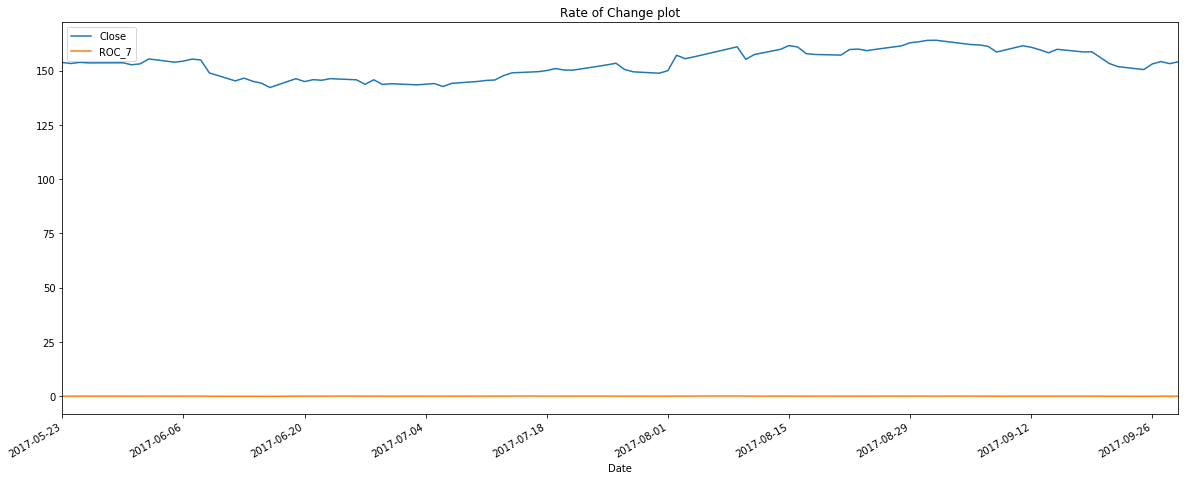

In [15]:
# Printing the ROC Indicator
print("RATE OF CHANGE")
stock_roc_df = ROC(stock_mom_df, 7)
# print stock_ema_df.info()
# print stock_ema_df.head()

print tabulate(stock_roc_df[['Close', 'ROC_7']].tail(10), headers='keys', tablefmt='psql')
plot_series(stock_roc_df, ['Close', 'ROC_7'], 90, 'Rate of Change plot')

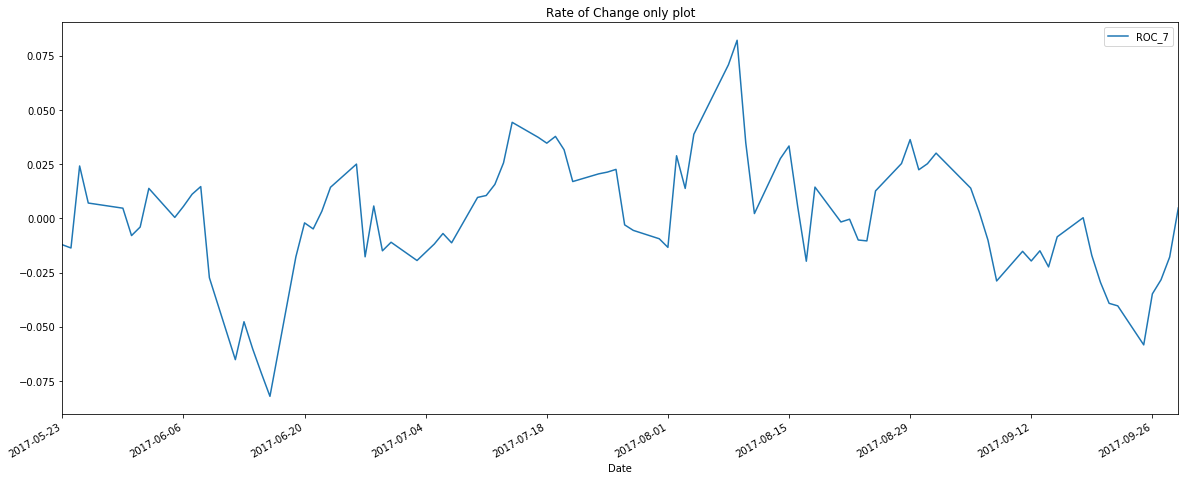

In [16]:
#Plot of the Rate of Change
plot_series(stock_roc_df, ['ROC_7'], 90, 'Rate of Change only plot')

## Moving average convergence divergence

Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of prices. The MACD is calculated by subtracting the 26-day exponential moving average (EMA) from the 12-day EMA. MACD functions as a trigger for buy and sell signals.

1. Crossovers - When the MACD falls below the signal line, it is a bearish signal, which indicates that it may be time to sell. Conversely, when the MACD rises above the signal line, the indicator gives a bullish signal, which suggests that the price of the stock is likely to experience upward momentum. 

2. Divergence - When the stock price diverges from the MACD, it signals the end of the current trend.

3. Dramatic rise - When the MACD rises dramatically - that is, the shorter moving average pulls away from the longer-term moving average - it is a signal that the stock is overbought and will soon return to normal levels.

http://www.investopedia.com/terms/m/macd.asp

In [17]:
# Implementation of the Moving Average Convergence Divergence (MACD) function
def MACD(df, n_fast, n_slow):
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=1).mean(), name='EMAfast')
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=1).mean(), name='EMAslow')

    name = 'MACD_' + str(n_fast) + '_' + str(n_slow)
    MACD = pd.Series(EMAfast - EMAslow, name = name)
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods = 1).mean(), 
                         name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))

    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df

MACD
+---------------------+---------+--------------+------------------+------------------+
| Date                |   Close |   MACD_12_26 |   MACDsign_12_26 |   MACDdiff_12_26 |
|---------------------+---------+--------------+------------------+------------------|
| 2017-09-18 00:00:00 |  158.67 |     0.77742  |         1.48938  |        -0.711956 |
| 2017-09-19 00:00:00 |  158.73 |     0.611024 |         1.31371  |        -0.702681 |
| 2017-09-20 00:00:00 |  156.07 |     0.261523 |         1.10327  |        -0.841746 |
| 2017-09-21 00:00:00 |  153.39 |    -0.229051 |         0.836805 |        -1.06586  |
| 2017-09-22 00:00:00 |  151.89 |    -0.730441 |         0.523356 |        -1.2538   |
| 2017-09-25 00:00:00 |  150.55 |    -1.22183  |         0.174319 |        -1.39615  |
| 2017-09-26 00:00:00 |  153.14 |    -1.3863   |        -0.137805 |        -1.2485   |
| 2017-09-27 00:00:00 |  154.23 |    -1.41242  |        -0.392727 |        -1.01969  |
| 2017-09-28 00:00:00 |  153.28 |    -

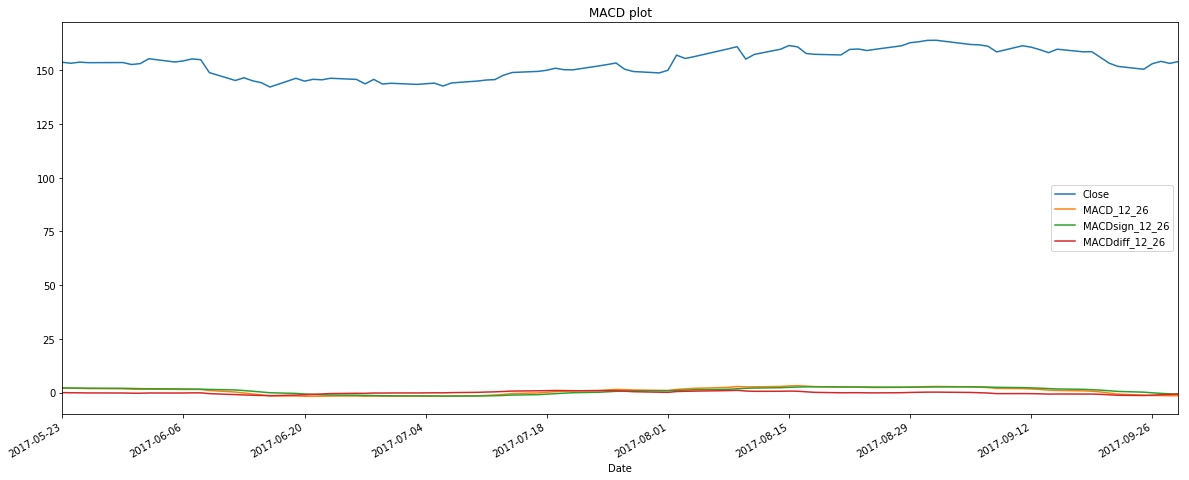

In [18]:
# Printing the Exponential Moving Average
print("MACD")
stock_macd_df = MACD(stock_ema_df,12,26)
# print stock_macd_df.info()
# print stock_macd_df.head()

print tabulate(stock_macd_df[['Close', 'MACD_12_26', 'MACDsign_12_26', 'MACDdiff_12_26']].tail(10), headers='keys', tablefmt='psql')
plot_series(stock_macd_df, ['Close', 'MACD_12_26', 'MACDsign_12_26', 'MACDdiff_12_26'], 90, 'MACD plot')

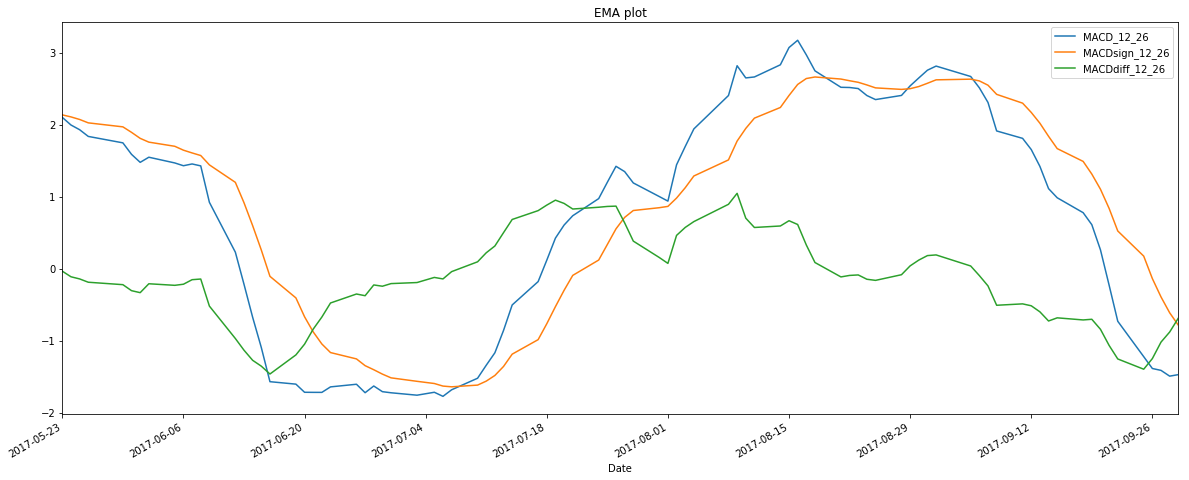

In [19]:
# Let's look at the MACD measures closely
plot_series(stock_macd_df, ['MACD_12_26', 'MACDsign_12_26', 'MACDdiff_12_26'], 90, 'EMA plot')

## Bollinger Bands

A Bollinger Band (BBANDS), developed by famous technical trader John Bollinger, is plotted two standard deviations away from a simple moving average. In this example of Bollinger Bands, the price of the stock is bracketed by an upper and lower band along with a 21-day simple moving average.

In [20]:
# Bollinger Bands  
def BBANDS(df, n):  
    MA = pd.Series(df['Close'].rolling(min_periods=1, center=False, window=n).mean(), name = 'MA1_' + str(n)) 
    MSD = pd.Series(df['Close'].rolling(min_periods=1, center=False, window=n).mean(), name = 'MSD_' + str(n))
    b1 = 4 * MSD / MA  
    B1 = pd.Series(b1, name = 'BollingerB_' + str(n))  
    df = df.join(B1)  
    b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)  
    B2 = pd.Series(b2, name = 'Bollinger%b_' + str(n))  
    df = df.join(B2)  
    return df

BOLLINGER BANDS
+---------------------+---------+-----------------+------------------+
| Date                |   Close |   BollingerB_21 |   Bollinger%b_21 |
|---------------------+---------+-----------------+------------------|
| 2017-09-18 00:00:00 |  158.67 |               4 |         0.497035 |
| 2017-09-19 00:00:00 |  158.73 |               4 |         0.497038 |
| 2017-09-20 00:00:00 |  156.07 |               4 |         0.492981 |
| 2017-09-21 00:00:00 |  153.39 |               4 |         0.489262 |
| 2017-09-22 00:00:00 |  151.89 |               4 |         0.487493 |
| 2017-09-25 00:00:00 |  150.55 |               4 |         0.486011 |
| 2017-09-26 00:00:00 |  153.14 |               4 |         0.490553 |
| 2017-09-27 00:00:00 |  154.23 |               4 |         0.492792 |
| 2017-09-28 00:00:00 |  153.28 |               4 |         0.491995 |
| 2017-09-29 00:00:00 |  154.12 |               4 |         0.493998 |
+---------------------+---------+-----------------+----------

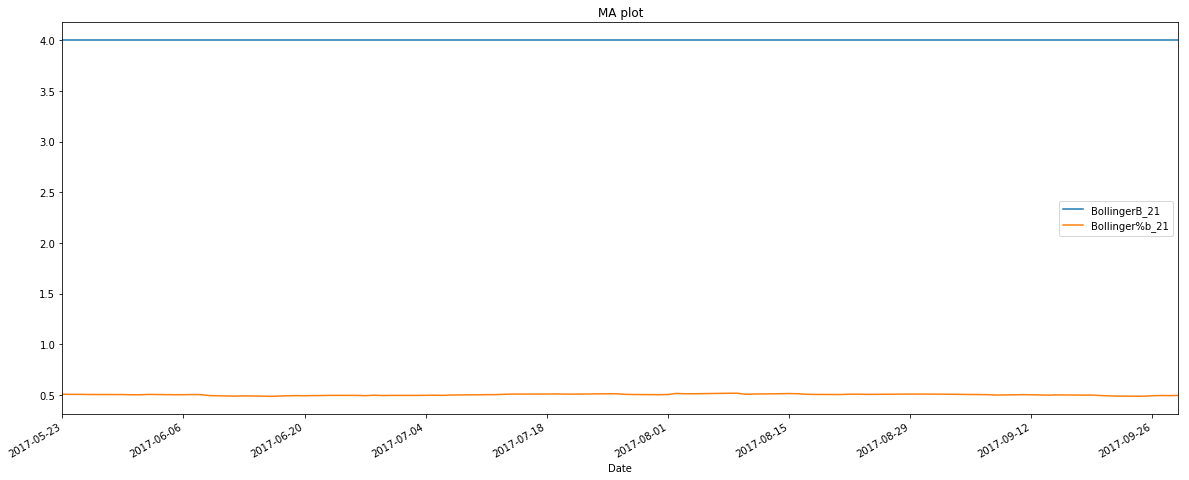

In [21]:
# Printing the Exponential Moving Average
print("BOLLINGER BANDS")
stock_bband_df = BBANDS(stock_ema_df, 21)
# print stock_macd_df.info()
# print stock_macd_df.head()

print tabulate(stock_bband_df[['Close', 'BollingerB_21', 'Bollinger%b_21']].tail(10), headers='keys', tablefmt='psql')
plot_series(stock_bband_df, ['BollingerB_21', 'Bollinger%b_21'], 90, 'MA plot')

## Pivot Points, Supports and Resistances 

A pivot point is a technical analysis indicator used to determine the overall trend of the market over different time frames. The pivot point itself is simply the average of the high, low and closing prices from the previous trading day. On the subsequent day, trading above the pivot point is thought to indicate ongoing bullish sentiment, while trading below the pivot point indicates bearish sentiment.

Support levels are where demand is perceived to be strong enough to prevent the price from falling further, while resistance levels are prices where selling is thought to be strong enough to prevent prices from rising higher.

http://www.investopedia.com/terms/p/pivotpoint.asp

In [22]:
# Pivot Points, Supports and Resistances  
def PPSR(df):  
    PP = pd.Series((df['High'] + df['Low'] + df['Close']) / 3)  
    R1 = pd.Series(2 * PP - df['Low'])  
    S1 = pd.Series(2 * PP - df['High'])  
    R2 = pd.Series(PP + df['High'] - df['Low'])  
    S2 = pd.Series(PP - df['High'] + df['Low'])  
    R3 = pd.Series(df['High'] + 2 * (PP - df['Low']))  
    S3 = pd.Series(df['Low'] - 2 * (df['High'] - PP))  
    psr = {'PP':PP, 'R1':R1, 'S1':S1, 'R2':R2, 'S2':S2, 'R3':R3, 'S3':S3}  
    PSR = pd.DataFrame(psr)  
    df = df.join(PSR)  
    return df

PIVOT POINTS, SUPPORTS AND RESISTANCES
+---------------------+---------+---------+---------+---------+---------+---------+---------+---------+
| Date                |   Close |      PP |      R1 |      S1 |      R2 |      S2 |      R3 |      S3 |
|---------------------+---------+---------+---------+---------+---------+---------+---------+---------|
| 2017-09-18 00:00:00 |  158.67 | 159.055 | 160.115 | 157.61  | 161.56  | 156.55  | 162.62  | 155.105 |
| 2017-09-19 00:00:00 |  158.73 | 158.98  | 159.52  | 158.19  | 160.31  | 157.65  | 160.85  | 156.86  |
| 2017-09-20 00:00:00 |  156.07 | 156.053 | 158.277 | 153.847 | 160.483 | 151.623 | 162.707 | 149.417 |
| 2017-09-21 00:00:00 |  153.39 | 153.98  | 155.21  | 152.16  | 157.03  | 150.93  | 158.26  | 149.11  |
| 2017-09-22 00:00:00 |  151.89 | 151.573 | 152.587 | 150.877 | 153.283 | 149.863 | 154.297 | 149.167 |
| 2017-09-25 00:00:00 |  150.55 | 150.513 | 151.867 | 149.197 | 153.183 | 147.843 | 154.537 | 146.527 |
| 2017-09-26 00:00:00 |  

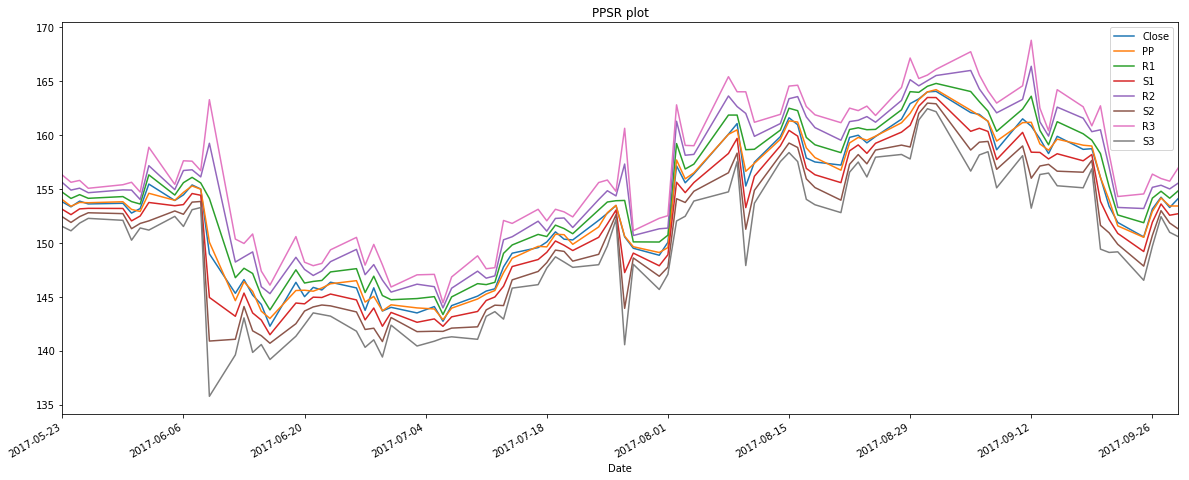

In [23]:
# Printing the Pivot Points, Supports and Resistances
print("PIVOT POINTS, SUPPORTS AND RESISTANCES")
stock_ppsr_df = PPSR(stock_ema_df)
# print stock_ppsr_df.info()
# print stock_ppsr_df.head()

print tabulate(stock_ppsr_df[['Close', 'PP', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3']].tail(10), headers='keys', tablefmt='psql')
plot_series(stock_ppsr_df, ['Close', 'PP', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3'], 90, 'PPSR plot')

## Stochastic Oscillators

An oscillator is a technical analysis tool that is banded between two extreme values and built with the results from a trend indicator for discovering short-term overbought or oversold conditions. As the value of the oscillator approaches the upper extreme value, the stock is deemed to be overbought, and as it approaches the lower extreme, it is deemed to be oversold.

Oscillators are most advantageous when a clear trend cannot be easily seen in a company's stock such as when it trades horizontally or sideways, and the most common oscillators are the stochastic oscillators.

http://www.investopedia.com/terms/o/oscillator.asp

In [24]:
# Now we are ready to explore two commmon ossicilators
# Stochastic oscillator %K  
def STOK(df):  
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name = 'SO%k')  
    df = df.join(SOk)  
    return df

# Stochastic oscillator %D
def STOD(df, n):  
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name = 'SO%k')  
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n-1).mean(), name = 'SO%d_' + str(n))  
    df = df.join(SOd)  
    return df

STOCHASTIC OSCILLATORS
+---------------------+---------+----------+
| Date                |   Close |     SO%k |
|---------------------+---------+----------|
| 2017-09-18 00:00:00 |  158.67 | 0.269461 |
| 2017-09-19 00:00:00 |  158.73 | 0.218045 |
| 2017-09-20 00:00:00 |  156.07 | 0.505643 |
| 2017-09-21 00:00:00 |  153.39 | 0.209836 |
| 2017-09-22 00:00:00 |  151.89 | 0.777778 |
| 2017-09-25 00:00:00 |  150.55 | 0.520599 |
| 2017-09-26 00:00:00 |  153.14 | 0.650224 |
| 2017-09-27 00:00:00 |  154.23 | 0.585291 |
| 2017-09-28 00:00:00 |  153.28 | 0.367089 |
| 2017-09-29 00:00:00 |  154.12 | 0.995305 |
+---------------------+---------+----------+


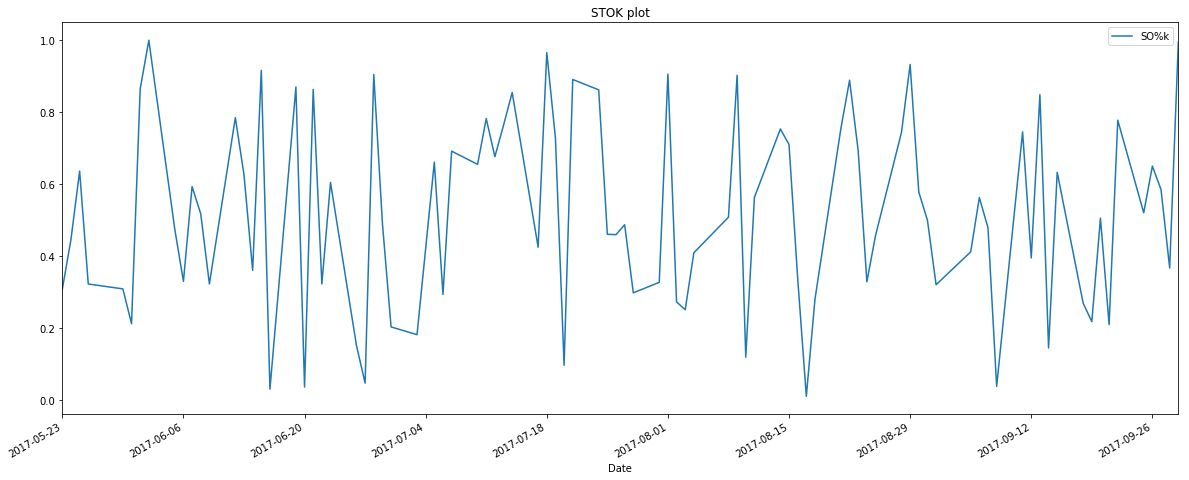

In [25]:
# Printing the Stochastic oscillator %K
print("STOCHASTIC OSCILLATORS")
stock_stok_df = STOK(stock_macd_df)

print tabulate(stock_stok_df[['Close', 'SO%k']].tail(10), headers='keys', tablefmt='psql')
plot_series(stock_stok_df, ['SO%k'], 90, 'STOK plot')

STOCHASTIC OSCILLATORS
+---------------------+---------+----------+
| Date                |   Close |   SO%d_7 |
|---------------------+---------+----------|
| 2017-09-18 00:00:00 |  158.67 | 0.441018 |
| 2017-09-19 00:00:00 |  158.73 | 0.385275 |
| 2017-09-20 00:00:00 |  156.07 | 0.415367 |
| 2017-09-21 00:00:00 |  153.39 | 0.363984 |
| 2017-09-22 00:00:00 |  151.89 | 0.467433 |
| 2017-09-25 00:00:00 |  150.55 | 0.480724 |
| 2017-09-26 00:00:00 |  153.14 | 0.523099 |
| 2017-09-27 00:00:00 |  154.23 | 0.538647 |
| 2017-09-28 00:00:00 |  153.28 | 0.495758 |
| 2017-09-29 00:00:00 |  154.12 | 0.620645 |
+---------------------+---------+----------+


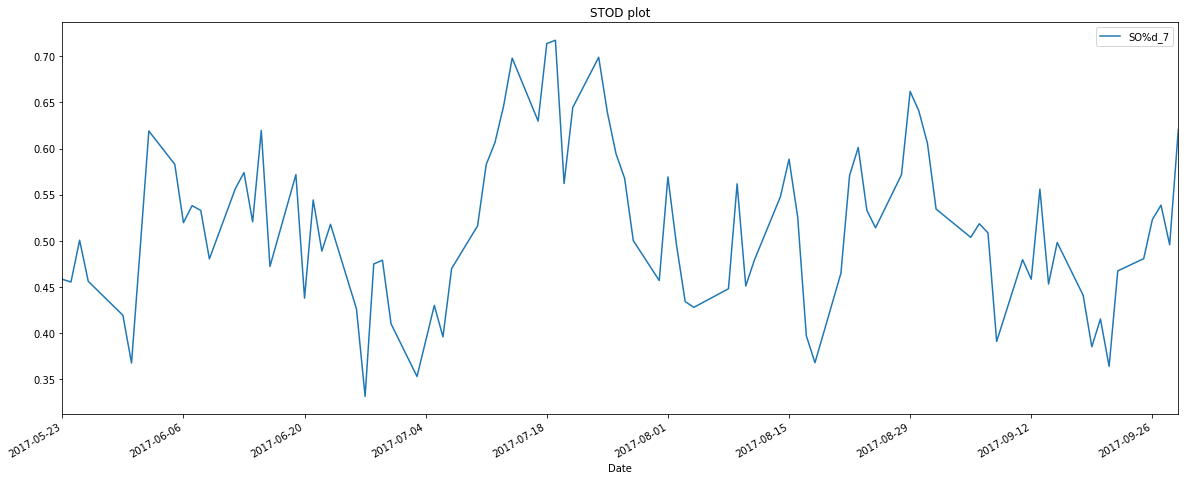

In [26]:
# Printing the Stochastic oscillator %D
print("STOCHASTIC OSCILLATORS")
stock_stod_df = STOD(stock_stok_df, 7)

print tabulate(stock_stod_df[['Close', 'SO%d_7']].tail(10), headers='keys', tablefmt='psql')
plot_series(stock_stod_df, ['SO%d_7'], 90, 'STOD plot')

## Ultimate Oscillator 

The Ultimate Oscillator is a technical indicator that uses the weighted average of three different time periods to reduce the volatility and false transaction signals that are associated with many other indicators that mainly rely on a single time period.
 
http://www.investopedia.com/terms/u/ultimateoscillator.asp#ixzz4vrfRFlqn 

In [27]:
# Ultimate Oscillator  
def ULTOSC(df):  
    # df.index = pd.to_datetime(df.pop('Date'))
    i = 0  
    TR_l = [0]  
    BP_l = [0]  
    df.reset_index(level=0, inplace=True)
    while i < df.index[-1]:  
        TR = max(df.get_value(i + 1, 'High'), df.get_value(i, 'Close')) 
        - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        TR_l.append(TR)  
        BP = df.get_value(i + 1, 'Close') 
        - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        BP_l.append(BP)  
        i = i + 1  
    UltO = pd.Series((4 * pd.Series(BP_l).rolling(window=7,center=False).sum() 
                        / pd.Series(TR_l).rolling(window=7,center=False).sum())
                     + (2 * pd.Series(BP_l).rolling(window=14,center=False).sum()
                        / pd.Series(TR_l).rolling(window=14,center=False).sum()) 
                     + (pd.Series(BP_l).rolling(window=28,center=False).sum() 
                        / pd.Series(TR_l).rolling(window=28,center=False).sum()), 
                     name = 'Ultimate_Osc')  
    df = df.join(UltO)  
    df.index = pd.to_datetime(df.pop('Date'))
    return df

ULTIMATE OSCILLATOR
+---------------------+---------+----------------+
| Date                |   Close |   Ultimate_Osc |
|---------------------+---------+----------------|
| 2017-09-18 00:00:00 |  158.67 |        6.93413 |
| 2017-09-19 00:00:00 |  158.73 |        6.93877 |
| 2017-09-20 00:00:00 |  156.07 |        6.92994 |
| 2017-09-21 00:00:00 |  153.39 |        6.92894 |
| 2017-09-22 00:00:00 |  151.89 |        6.92655 |
| 2017-09-25 00:00:00 |  150.55 |        6.92679 |
| 2017-09-26 00:00:00 |  153.14 |        6.92799 |
| 2017-09-27 00:00:00 |  154.23 |        6.93362 |
| 2017-09-28 00:00:00 |  153.28 |        6.9352  |
| 2017-09-29 00:00:00 |  154.12 |        6.94543 |
+---------------------+---------+----------------+


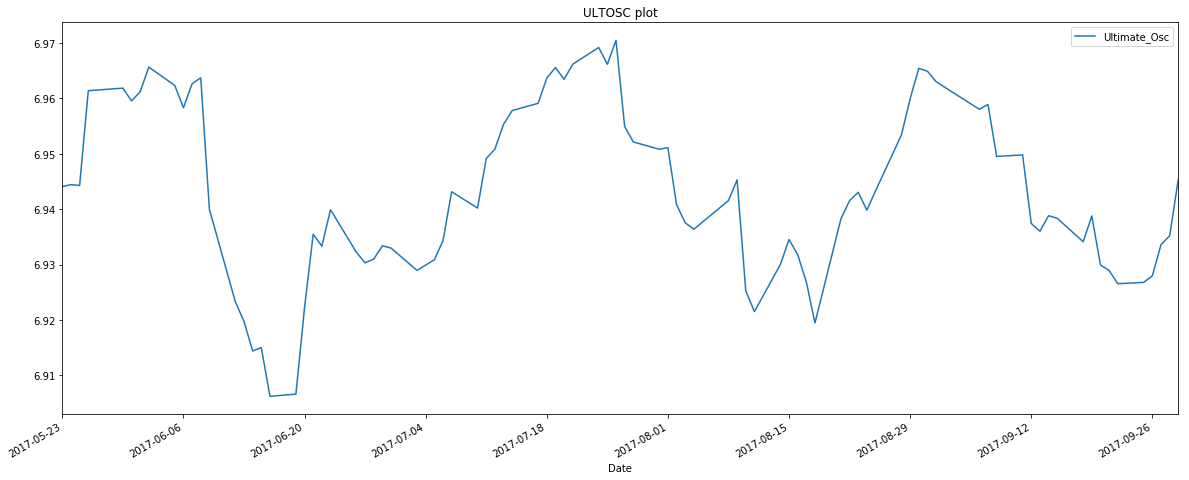

In [28]:
# Printing the Ultimate Oscillator
print("ULTIMATE OSCILLATOR")
stock_ultsoc_df = ULTOSC(stock_stod_df)

print tabulate(stock_ultsoc_df[['Close', 'Ultimate_Osc']].tail(10), headers='keys', tablefmt='psql')
plot_series(stock_ultsoc_df, ['Ultimate_Osc'], 90, 'ULTOSC plot')

# Fundamentals and Macroeconomic data

The fundamentals include the qualitative and quantitative information that contributes to the economic well-being and the subsequent financial valuation of a company, stock or currency. Analysts and investors analyze these fundamentals to develop an estimate as to whether the underlying asset is considered a worthwhile investment. 

For businesses, information such as revenue, earnings, assets, liabilities and growth are considered some of the fundamentals. In this section we will show how to collect stock fundamentals data from the Quandl API (an API key is requried for these calls).

http://www.investopedia.com/terms/f/fundamentals.asp

In [29]:
# data = quandl.get_table('MER/F1', paginate=True)
# for index, row in symbol_df.iterrows():
#    print row['Symbol']
#    data = quandl.get_table('ZACKS/FC', ticker = row['Symbol'])
#    print(data)

# This API call returns 250 columns
fund_df = quandl.get_table('ZACKS/FC', ticker='AAPL')
fund_df2 = quandl.get_table('ZACKS/CP', ticker='AAPL')

In [30]:
fund_df.info()
fund_df.columns
# print tabulate(fund_df.tail(10), headers='keys', tablefmt='psql')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Columns: 249 entries, m_ticker to eps_diluted_net
dtypes: datetime64[ns](7), float64(109), int64(10), object(123)
memory usage: 66.2+ KB


Index([u'm_ticker', u'ticker', u'comp_name', u'comp_name_2', u'exchange',
       u'currency_code', u'per_end_date', u'per_type', u'per_code',
       u'per_fisc_year',
       ...
       u'stock_based_compsn_qd', u'cash_flow_oper_activity_qd',
       u'net_change_prop_plant_equip_qd', u'comm_stock_div_paid_qd',
       u'pref_stock_div_paid_qd', u'tot_comm_pref_stock_div_qd',
       u'wavg_shares_out', u'wavg_shares_out_diluted', u'eps_basic_net',
       u'eps_diluted_net'],
      dtype='object', length=249)

In [31]:
#Daily USA Gold Prices
print("Daily USA Gold Prices")
gold_df = quandl.get("WGC/GOLD_DAILY_USD", start_date=start, end_date=end)
print tabulate(gold_df.tail(10), headers='keys', tablefmt='psql')

Daily USA Gold Prices
+---------------------+---------+
| Date                |   Value |
|---------------------+---------|
| 2017-09-18 00:00:00 |  1312.1 |
| 2017-09-19 00:00:00 |  1309.6 |
| 2017-09-20 00:00:00 |  1311.3 |
| 2017-09-21 00:00:00 |  1292.1 |
| 2017-09-22 00:00:00 |  1294.8 |
| 2017-09-25 00:00:00 |  1293.3 |
| 2017-09-26 00:00:00 |  1300.1 |
| 2017-09-27 00:00:00 |  1282.6 |
| 2017-09-28 00:00:00 |  1283.4 |
| 2017-09-29 00:00:00 |  1283.1 |
+---------------------+---------+


In [32]:
#Cushing, OK WTI Spot Price FOB, Daily
print("Cushing, OK WTI Spot Price FOB, Daily")
print("US Energy Information Administration Data")
oil_df = quandl.get("EIA/PET_RWTC_D", start_date=start, end_date=end)
print tabulate(oil_df.tail(10), headers='keys', tablefmt='psql')

Cushing, OK WTI Spot Price FOB, Daily
US Energy Information Administration Data
+---------------------+---------+
| Date                |   Value |
|---------------------+---------|
| 2017-09-18 00:00:00 |   49.88 |
| 2017-09-19 00:00:00 |   49.54 |
| 2017-09-20 00:00:00 |   50.29 |
| 2017-09-21 00:00:00 |   50.58 |
| 2017-09-22 00:00:00 |   50.33 |
| 2017-09-25 00:00:00 |   51.85 |
| 2017-09-26 00:00:00 |   51.59 |
| 2017-09-27 00:00:00 |   52.14 |
| 2017-09-28 00:00:00 |   51.62 |
| 2017-09-29 00:00:00 |   51.67 |
+---------------------+---------+


In [33]:
#Natural Rate of Unemployment (Short Term)
print("Natural Rate of Unemployment (Short-term)")
s_uemp_df = quandl.get("FRED/NROUST", start_date=start, end_date=end)
print tabulate(s_uemp_df.tail(10), headers='keys', tablefmt='psql')

Natural Rate of Unemployment (Short-term)
+---------------------+---------+
| Date                |   Value |
|---------------------+---------|
| 2017-04-01 00:00:00 |    4.74 |
| 2017-07-01 00:00:00 |    4.74 |
| 2017-10-01 00:00:00 |    4.74 |
+---------------------+---------+


In [34]:
#Natural Rate of Unemployment (Long Term)
print("Natural Rate of Unemployment (Long-term)")
l_uemp_df = quandl.get("FRED/NROU", start_date=start, end_date=end)
print tabulate(l_uemp_df.tail(10), headers='keys', tablefmt='psql')

Natural Rate of Unemployment (Long-term)
+---------------------+---------+
| Date                |   Value |
|---------------------+---------|
| 2017-04-01 00:00:00 |    4.74 |
| 2017-07-01 00:00:00 |    4.74 |
| 2017-10-01 00:00:00 |    4.74 |
+---------------------+---------+


In [35]:
#Real Potential Gross Domestic Product
print("Real Potential Gross Domestic Product")
gdp_df = quandl.get("FRED/GDPPOT", start_date=start, end_date=end)
print tabulate(gdp_df.tail(10), headers='keys', tablefmt='psql')

Real Potential Gross Domestic Product
+---------------------+---------+
| Date                |   Value |
|---------------------+---------|
| 2017-04-01 00:00:00 | 17058.2 |
| 2017-07-01 00:00:00 | 17125.5 |
| 2017-10-01 00:00:00 | 17194.2 |
+---------------------+---------+


# Next Steps

The models developed from Technical Analysis can be viewed as "screeners" for securities with daily trade data. In the second part of the project we explore algorithmic trading strategies using the Technical Analysis models as input. This work was done using the tools provided by the Quantopian service.